# Notebook 11 - Classification: A more difficult dataset

## 11.1 Load CIFAR-10 Data Set

**Description:** A dataset of 60,000 color images ($32 \times 32$ pixels) in 10 classes (e.g., airplane, car, bird, cat, deer, dog, frog, horse, ship, truck).

CIFAR-10 is harder than MNIST because the images are colored and contain more complex patterns and noise. Regression would struggle due to the non-linear structure and high-dimensional data, but CNNs can effectively handle spatial patterns. It is slightly more computationally demanding than MNIST due to the additional complexity of RGB channels.

**Task:**

As a first step, you only have to go through the next steps and inspect the data set.

In [29]:
import tensorflow as tf

# Load CIFAR-10 dataset
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train_cifar = X_train_cifar.astype("float32") / 255.0
X_test_cifar = X_test_cifar.astype("float32") / 255.0

# Convert labels to one-hot encoding if needed
y_train_cifar = tf.keras.utils.to_categorical(y_train_cifar, 10)
y_test_cifar = tf.keras.utils.to_categorical(y_test_cifar, 10)

print("Training data shape:", X_train_cifar.shape)
print("Training labels shape:", y_train_cifar.shape)


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)


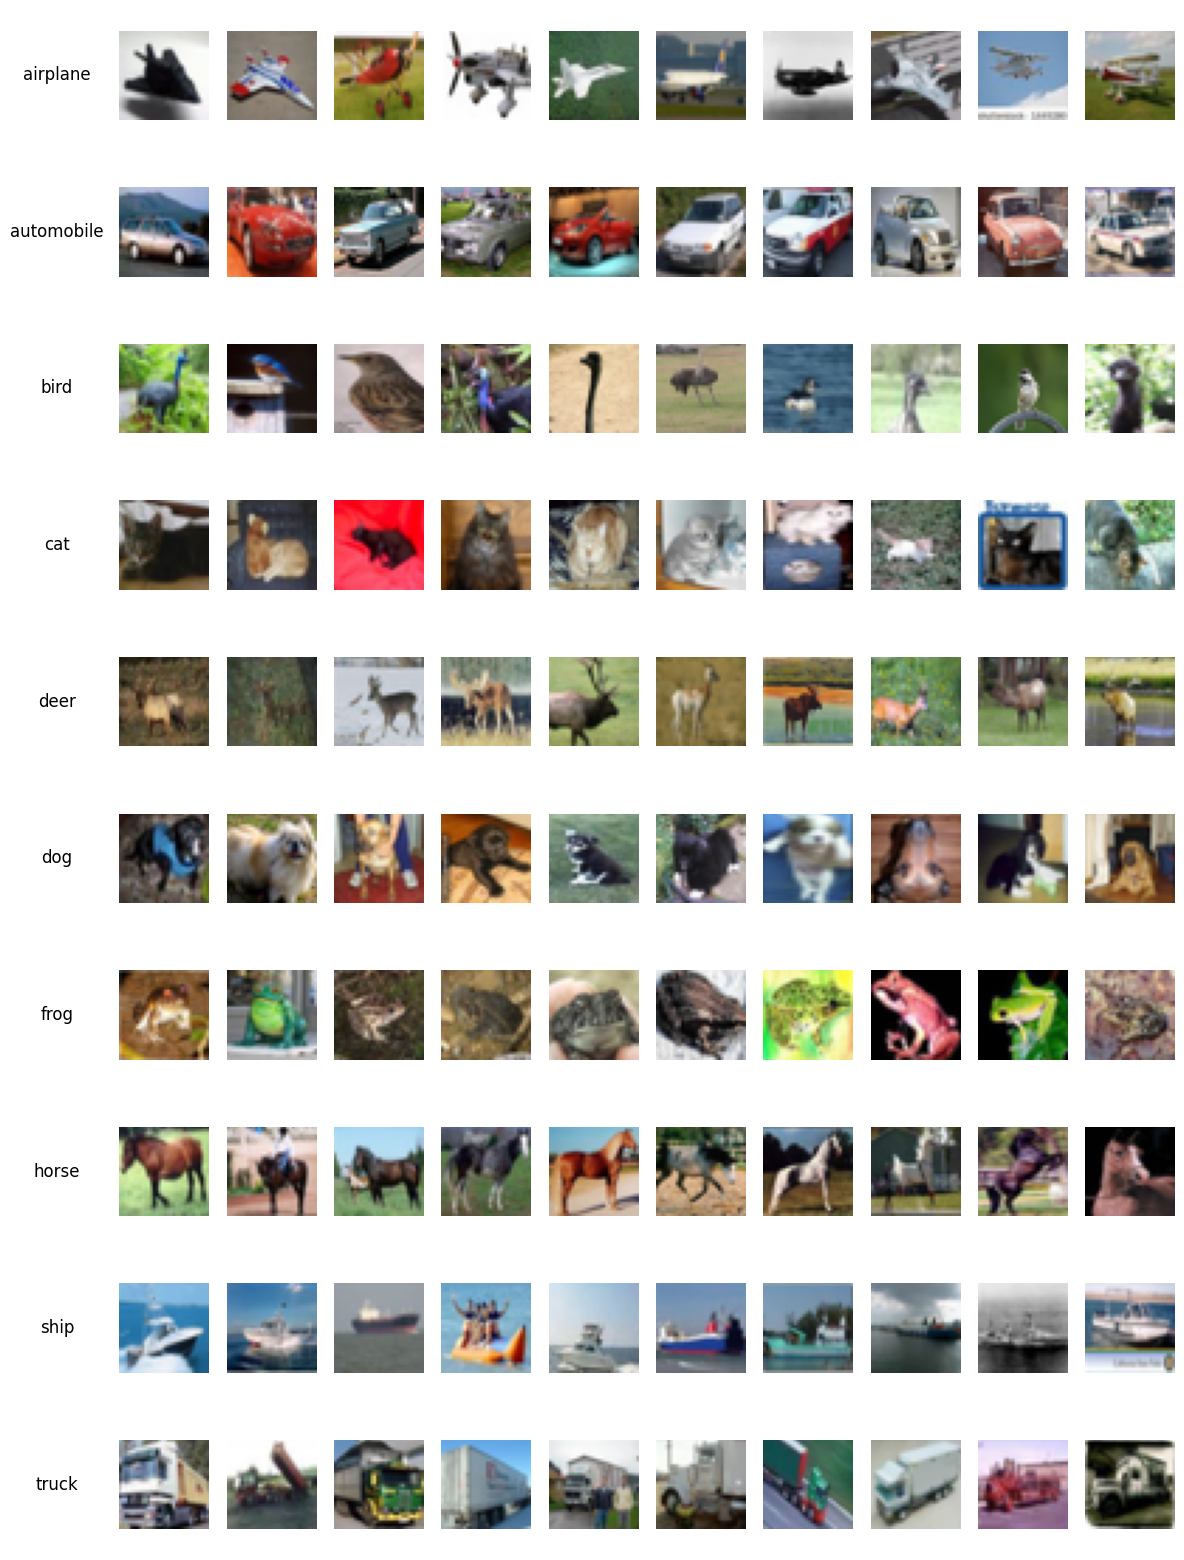

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names for CIFAR-10
classes_cifar = ['airplane', 'automobile', 'bird', 'cat', 
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Group 10 examples per class
examples_per_class = 10
rows = len(classes_cifar)
fig, axes = plt.subplots(rows, examples_per_class + 1, figsize=(15, rows * 2))

# Loop through each class
for class_idx, class_name in enumerate(classes_cifar):
    # Display the class name in the first column
    axes[class_idx, 0].text(
        0.5, 0.5, class_name, ha='center', va='center', fontsize=12
    )
    axes[class_idx, 0].axis("off")  # Turn off the axis for text cells

    # Find indices of the first 10 images for the current class
    class_indices = np.where(np.argmax(y_train_cifar, axis=1) == class_idx)[0][:examples_per_class]
    for j, idx in enumerate(class_indices):
        ax = axes[class_idx, j + 1]
        ax.imshow(X_train_cifar[idx])
        ax.axis("off")

plt.show()


--- 

## 11.2 Applying a Convolutional Neural Network Architecture

We started with the LeNet-5 architecture, a classic CNN architecture designed by Yann LeCun for handwritten digit recognition. LeNet-5 was well-suited for the MNIST dataset and includes several convolutional and pooling layers, followed by fully connected layers. 

* Input Layer: Accepts 28x28 grayscale images as input, with each image normalized to a range of 0–1 (we added padding).
* Convolutional Layer 1: Applies 6 filters of size 5x5 with stride 1 and ReLU activation, producing 6 feature maps. The resulting feature maps have dimensions of 24x24.
* Pooling Layer 1 (Average Pooling): Averages over 2x2 regions, reducing each feature map to a size of 12x12. Pooling reduces the spatial dimensions and adds robustness to small spatial translations.
* Convolutional Layer 2: Applies 16 filters of size 5x5 with stride 1 and ReLU activation, producing 16 feature maps. The resulting feature maps have dimensions of 8x8.
* Pooling Layer 2 (Average Pooling): Another 2x2 average pooling layer, reducing each feature map to a size of 4x4.
* Fully Connected Layers:
   - Fully Connected Layer 1: Flattens the output from the convolutional layers and connects to a fully connected layer with 120 neurons and ReLU activation.
   - Fully Connected Layer 2: Connects to a fully connected layer with 84 neurons and ReLU activation.
* Output Layer: The final layer is a fully connected layer with 10 neurons and softmax activation, used for classification into the 10 digit classes.

Modern convolutional neural network mostly changed towards smaller filters -- but sometimes stacking multiple of these smaller convolutions on top of each other.
A typical block structure in a convolutional NN combines:

* Convolutional Layer: Applies $32$ filters of size $3 \times 3$ with stride 1 and ReLU activation, producing 32 feature maps (with padding set to `same` which means that the resulting feature map has the same dimensions of $32 \times 32$ as the input).
* Convolutional Layer: Applies $32$ filters of size $3 \times 3$ with stride 1 and ReLU activation
* Pooling Layer (Max Pooling): Takes thes maximum over $2 \times 2$ regions, reducing each feature map to a size by the factor of 2. Pooling reduces the spatial dimensions and adds robustness to small spatial translations.

Multiple of these blocks are stacked and (after flattening) followed by a Dense layer and an output layer (with softmax activation for classification).

Such an approach performs quite well for the given task: We can reach a **validation accuracy of around $60 \%$**.

**Tasks:**

You can simply compare the different architectures and effects of your variations:

* increasing training data (for further variations might have to go back to smaller data set again to speed up training)
* using normalization on the input data (gray scale values are encoded from 0 to 255 = scale it into the range $[0,1]$)
* activation function (last week we already used ReLU, but originally LeNet used sigmoid): compare ReLU and sigmoid (on smaller training data set); how does this interacts with normalization?
* adding Dropout as regularization
* using early stopping
* and Batch Normalization

In [31]:
import tensorflow as tf
import numpy as np
import optuna
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load and preprocess data
(X_train_full, y_train_full), (X_test_cifar, y_test_cifar) = tf.keras.datasets.cifar10.load_data()

# Normalize to [0, 1]
X_train_full = X_train_full.astype("float32") / 255.0
X_test_cifar = X_test_cifar.astype("float32") / 255.0

# Reduce data size for speed
X_train_cifar, _, y_train_cifar, _ = train_test_split(X_train_full, y_train_full, train_size=0.2, stratify=y_train_full)

# One-hot encode labels
y_train_cifar = to_categorical(y_train_cifar, num_classes=10)
y_test_cifar = to_categorical(y_test_cifar, num_classes=10)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# We use optuna to try out different hyperparameters and select the best performing ones
def objective(trial):
    # Hyperparameters to optimize
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid"])
    use_batch_norm = trial.suggest_categorical("batch_norm", [True, False])
    use_dropout = trial.suggest_categorical("dropout", [True, False])
    use_es = trial.suggest_categorical("early_stopping", [True, False])
    dropout_rate = 0.3 # For brevity, we only test one value of dropout. Other common choices would be 0.2 or 0.3.
    learning_rate = 0.001 # For the same reason, we fix LR also.
    # learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(6, (5, 5), padding='same', input_shape=(32, 32, 3)))
    if use_batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))

    model.add(tf.keras.layers.Conv2D(16, (5, 5), padding='same'))
    if use_batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    model.add(tf.keras.layers.AveragePooling2D((2, 2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(120))
    if use_batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    if use_dropout:
        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(84))
    if use_batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    if use_dropout:
        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    history = model.fit(
        X_train_cifar, y_train_cifar,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        callbacks=[early_stopping] if use_es else None,
        verbose=0
    )

    val_acc = max(history.history["val_accuracy"])
    return val_acc

# Run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2**4) # Number of trials according to number of parameter combinations

study.best_params

[I 2025-07-10 08:42:26,961] A new study created in memory with name: no-name-b0f64909-6dbd-4e28-90ab-1695b1503b69
/home/flo/.conda/envs/tutorial/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-07-10 08:42:50,965] Trial 0 finished with value: 0.4180000126361847 and parameters: {'activation': 'sigmoid', 'batch_norm': False, 'dropout': False, 'early_stopping': False}. Best is trial 0 with value: 0.4180000126361847.
[I 2025-07-10 08:43:30,828] Trial 1 finished with value: 0.4519999921321869 and parameters: {'activation': 'sigmoid', 'batch_norm': True, 'dropout': False, 'early_stopping': False}. Best is trial 1 with value: 0.4519999921321869.
[I 2025-07-10 08:44:10,842] Trial 2 finished with value: 0.5

{'activation': 'relu',
 'batch_norm': True,
 'dropout': True,
 'early_stopping': True}

/home/flo/.conda/envs/tutorial/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.1728 - loss: 2.1644 - val_accuracy: 0.3454 - val_loss: 1.7750
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.3372 - loss: 1.7723 - val_accuracy: 0.4136 - val_loss: 1.5846
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.4063 - loss: 1.5831 - val_accuracy: 0.4398 - val_loss: 1.5137
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.4636 - loss: 1.4624 - val_accuracy: 0.5038 - val_loss: 1.3733
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.5261 - loss: 1.2955 - val_accuracy: 0.5401 - val_loss: 1.3125
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5626 - loss: 1.2159 - val_accuracy: 0.5810 - val_loss: 1.1803
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.6187 - loss: 1.0661 - val_accuracy: 0.5898 - val_loss: 1.1721
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.6460 - loss: 0.9927 - 

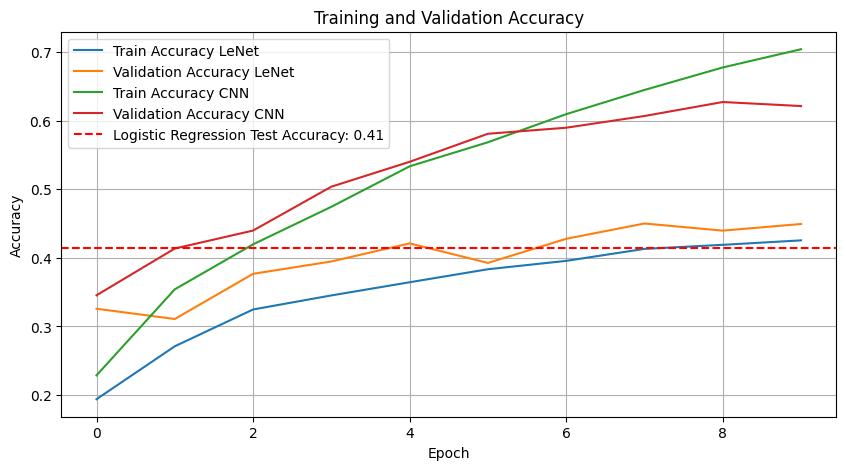

CNN Test Accuracy: 0.6214
LeNet5 Test Accuracy: 0.4494


In [32]:
# Define the LeNet-5 architecture with the best parameters
model_lenet5 = tf.keras.models.Sequential([
    # Convolutional Layer 1: 6 filters of size 5x5, stride 1, with ReLU activation
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1, input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Average Pooling Layer 1: pool size 2x2
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    # Convolutional Layer 2: 16 filters of size 5x5, stride 1, with ReLU activation
    # Batch normalization - remove the single line for Conv2D and replace it by the three following steps
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Average Pooling Layer 2: pool size 2x2
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    # Flatten layer to reshape 2D feature maps to a 1D vector
    tf.keras.layers.Flatten(),
    # Fully Connected Layer 1: 120 units with ReLU activation
    # Batch normalization - remove the single line for Dense and replace it by the three following steps
    tf.keras.layers.Dense(120),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Dropout
    tf.keras.layers.Dropout(0.5),
    # Fully Connected Layer 2: 84 units with ReLU activation
    # Batch normalization - remove the single line for Dense and replace it by the three following steps
    tf.keras.layers.Dense(84),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Dropout
    tf.keras.layers.Dropout(0.5),
    # Output Layer: 10 units with softmax activation for classification
    tf.keras.layers.Dense(10, activation='softmax')
    # Originally used Radial Basis Functions in LeNet-5
])

# Define the CNN model
model_cnn = tf.keras.models.Sequential([
    # Convolutional Block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (e.g., validation loss)
    patience=5,            # Number of epochs with no improvement to stop training
    restore_best_weights=True  # Restore model weights from the epoch with the best metric value
)

# Compile the model
model_lenet5.compile(optimizer=Adam(learning_rate=0.001), # Set your desired learning rate (default is 0.001, learning_rate is a parameter you can set)
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_cnn = model_cnn.fit(X_train_cifar, y_train_cifar,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_test_cifar, y_test_cifar),
                                  verbose=1)

history_lenet5 = model_lenet5.fit(X_train_cifar, y_train_cifar,
                                  epochs=10,
                                  batch_size=32,
                                  validation_data=(X_test_cifar, y_test_cifar),
                                  verbose=1)

# For comparison: This was the accuracy after 20 iterations using logistic regression 
# (we tested earlier and seemed already converged; in a second run for 100 iterations it reached 0.4032 on the test set)
logistic_regression_accuracy = 0.4138

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.plot(history_lenet5.history['accuracy'], label='Train Accuracy LeNet')
plt.plot(history_lenet5.history['val_accuracy'], label='Validation Accuracy LeNet')
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy CNN')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy CNN')
# Add the logistic regression test accuracy as a horizontal line
plt.axhline(y=logistic_regression_accuracy, color='red', linestyle='--', label=f'Logistic Regression Test Accuracy: {logistic_regression_accuracy:.2f}')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# Evaluate the model on the test set
_, test_accuracy_cnn = model_cnn.evaluate(X_test_cifar, y_test_cifar, verbose=0)
_, test_accuracy_lenet5 = model_lenet5.evaluate(X_test_cifar, y_test_cifar, verbose=0)
print(f"CNN Test Accuracy: {test_accuracy_cnn:.4f}")
print(f"LeNet5 Test Accuracy: {test_accuracy_lenet5:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


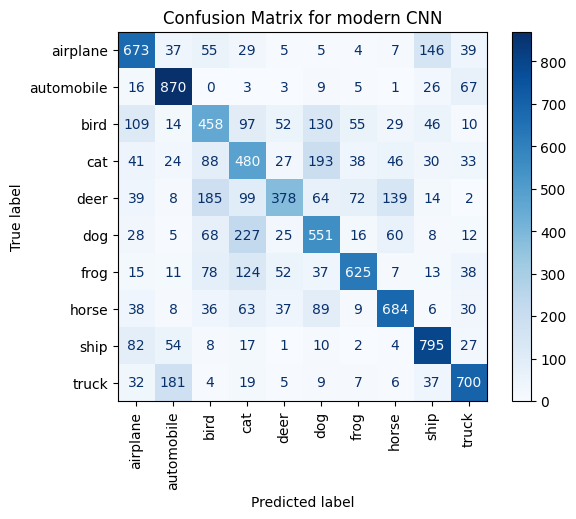

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
predictions_cnn = model_cnn.predict(X_test_cifar)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions_cnn, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_cifar.argmax(axis=1), predicted_classes)

# Display the confusion matrix with class names
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=classes_cifar)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for modern CNN")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


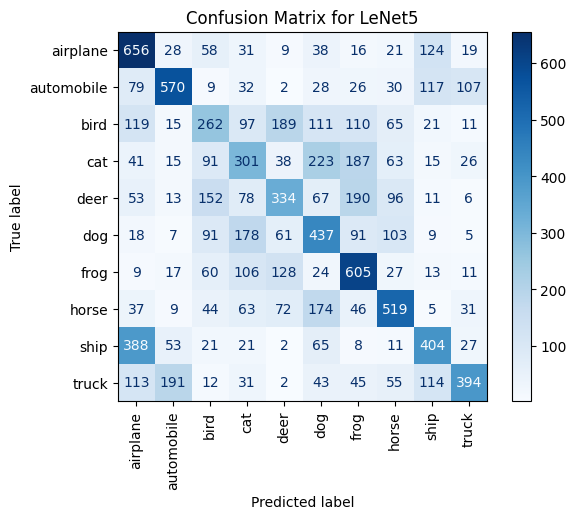

In [41]:
predictions_lenet5 = model_lenet5.predict(X_test_cifar)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions_lenet5, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_cifar.argmax(axis=1), predicted_classes)

# Display the confusion matrix with class names
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=classes_cifar)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for LeNet5")
plt.show()


## Remarks on different topics / Explanation

### Normalization
Normalization scales input features to a common range, typically [0, 1] or [-1, 1], ensuring that each feature contributes equally to the model's training. It is especially critical when using activation functions like sigmoid or tanh, which are sensitive to input magnitude and can saturate, leading to vanishing gradients. With ReLU, normalization becomes less critical because ReLU does not saturate for positive inputs. However, normalized inputs still help by improving convergence speed and ensuring consistent gradient magnitudes across layers.

### Effect of More Data
Adding more data can significantly improve model performance, especially by reducing overfitting and enhancing generalization. Models trained on larger datasets can better capture the underlying patterns and variability of the data, leading to improved predictions on unseen samples. However, simply adding more data without diversity or relevance may not yield benefits. High-quality, diverse data ensures that the model is exposed to a wide range of scenarios during training, boosting its ability to generalize.

### Dropout and Regularization
Dropout is a popular regularization technique that prevents overfitting by randomly setting a fraction of neurons to zero during training. This forces the network to learn more robust features, as it cannot rely on any single neuron. Dropout complements other regularization techniques, such as L2 regularization, which penalizes large weights to reduce model complexity. While dropout is effective, using it excessively can lead to underfitting, so it should be applied judiciously, especially in conjunction with Batch Normalization.

### Early Stopping
Early stopping halts training when the model's performance on a validation set stops improving for a specified number of epochs. This prevents overfitting, as the model stops learning patterns specific to the training data. By restoring the weights from the epoch with the best validation performance, early stopping ensures optimal generalization. It is particularly effective in scenarios where the model is prone to overfitting or when computational resources are limited.

### Batch Normalization
Batch Normalization (BatchNorm) normalizes the activations of each layer by adjusting and scaling them during training. This stabilizes learning, reduces the risk of vanishing or exploding gradients, and allows for higher learning rates. BatchNorm also acts as a form of regularization, reducing the need for other techniques like dropout. It is especially useful in deeper networks, where it accelerates convergence and makes the model more robust to weight initialization and learning rate choices.


In [43]:
def plot_image(i, predictions_array, true_array, img):
  true_label, img = np.argmax(true_array[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classes_cifar[predicted_label],
                                100*np.max(predictions_array),
                                classes_cifar[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_array):
  true_label = np.argmax(true_array[i])
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [44]:
predictions = model_lenet5.predict(X_test_cifar)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


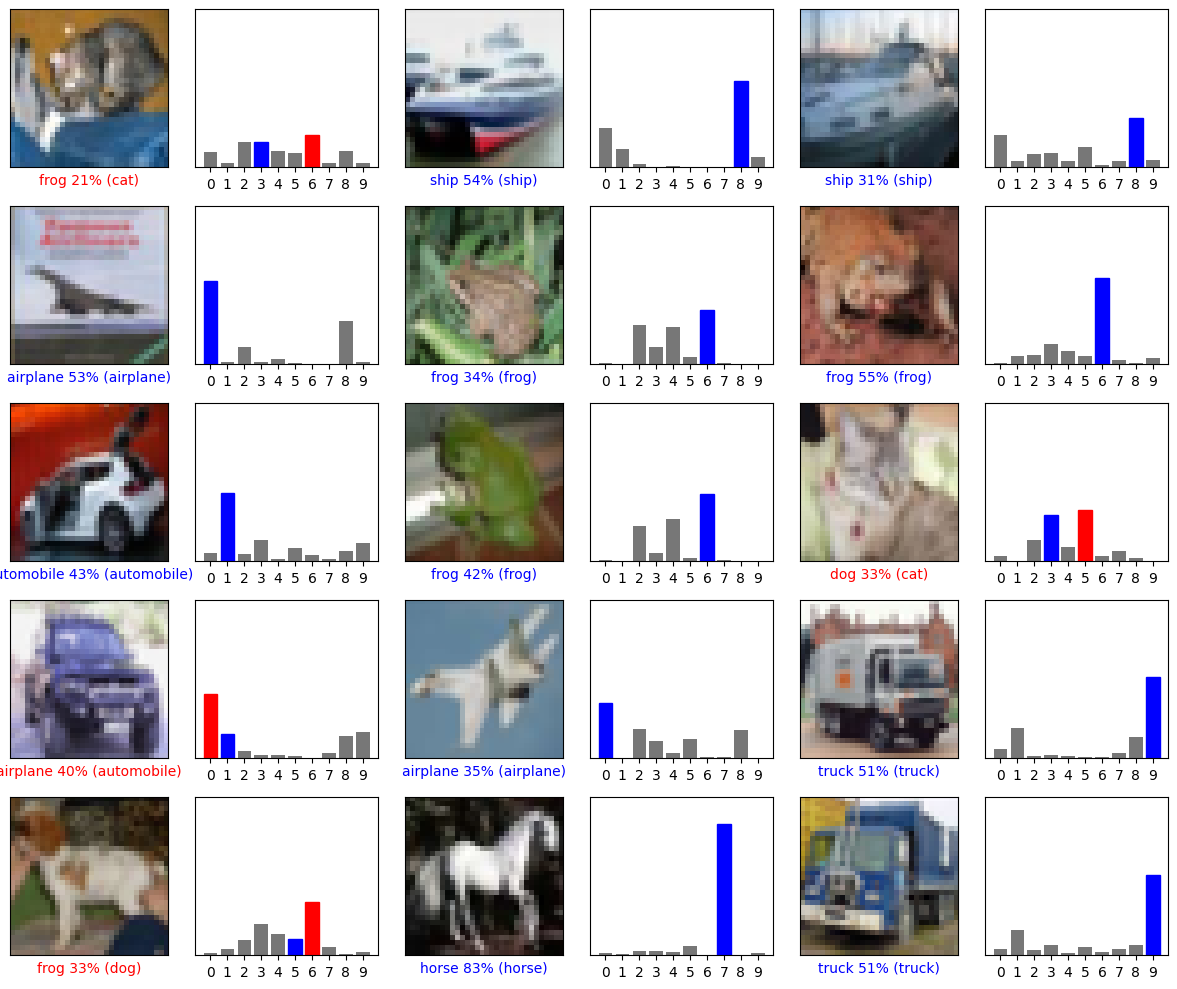

In [45]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test_cifar, X_test_cifar)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test_cifar)
plt.tight_layout()
plt.show()


## 11.3 Comparing image dataset performance

We will briefly work with a new data set - with a similar structure: The Fashion MNIST Dataset. Each image in the Fashion MNIST dataset is again 28x28 pixels, unrolled into a 784-dimensional vector for modeling (our input space). We transfer the labels to one-hot encoded targets.

Our goal is to compare the performance of the same LeNet-5 architecture between both datasets

**Task:**

The following code loads the Fashion MNIST dataset and displays examples.
1. Implement the same architecture as for CIFAR and make changes necessary to accomodate differences in the dataset if necessary. 
2. Train the model. You can either use similar parameters or optimize them for both models separately.
3. Evaluate both models/datasets and display the confusion matrix. Which dataset seems easier for the model? What might be the cause? Do you have an idea what changes are likely to improve the performance on the harder dataset?

In [17]:
classes_fmnist = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load MNIST dataset
#mnist = fetch_openml('mnist_784', version=1, as_frame=False)
#X, y = mnist["data"], mnist["target"].astype(int)

# Fetch the Fashion-MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
# Separate the features (X) and labels (y)
X, y = fashion_mnist['data'], fashion_mnist['target']
# Convert labels to integers (if needed)
y = y.astype(np.int64)

In [19]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

# Split into training and test sets
X_train_fmnist, X_test_fmnist, y_train_fmnist, y_test_fmnist = train_test_split(X, y_one_hot, train_size=1000, test_size=10000, random_state=42, stratify=y)

# Display shapes of the resulting datasets
print("Training set shape:", X_train_fmnist.shape, y_train_fmnist.shape)
print("Test set shape:", X_test_fmnist.shape, y_test_fmnist.shape)

# Add normalization
X_train_fmnist = X_train_fmnist / 255.0
X_test_fmnist = X_test_fmnist / 255.0
print(X_train_fmnist.max())

# Reshape the data to include a single channel for grayscale images (28x28x1)
X_train_cnn = X_train_fmnist.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_fmnist.reshape(-1, 28, 28, 1)

Training set shape: (1000, 784) (1000, 10)
Test set shape: (10000, 784) (10000, 10)
1.0


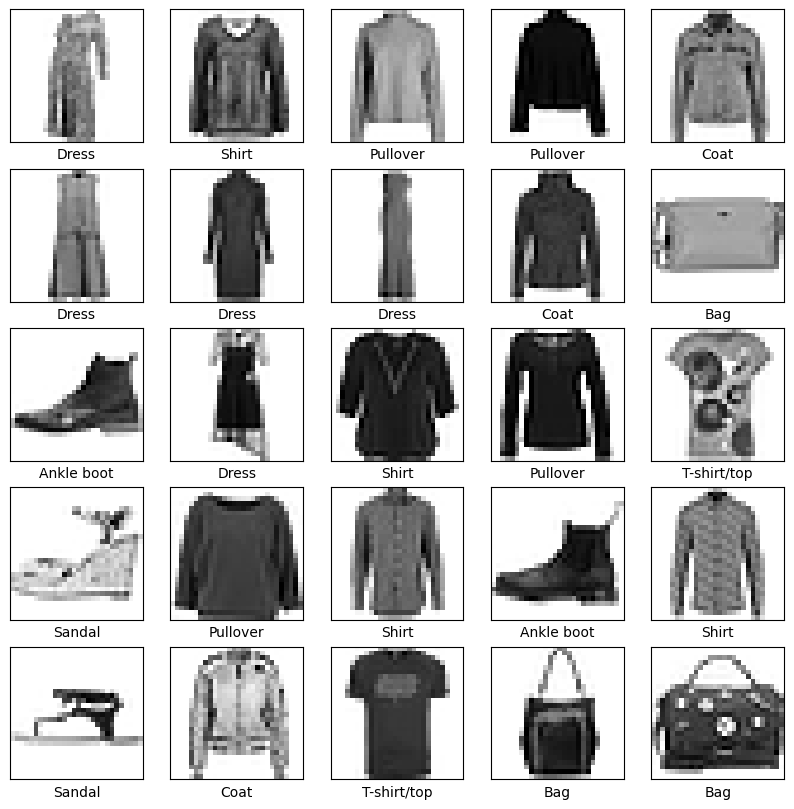

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_cnn[i], cmap=plt.cm.binary)
    plt.xlabel(classes_fmnist[np.argmax(y_train_fmnist[i])])
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam
# Fit the model on Fashion MNIST
model_lenet5_fmnist = tf.keras.models.Sequential([
    # Convolutional Layer 1: 6 filters of size 5x5, stride 1, with ReLU activation
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1, input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Average Pooling Layer 1: pool size 2x2
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    # Convolutional Layer 2: 16 filters of size 5x5, stride 1, with ReLU activation
    # Batch normalization - remove the single line for Conv2D and replace it by the three following steps
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Average Pooling Layer 2: pool size 2x2
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    # Flatten layer to reshape 2D feature maps to a 1D vector
    tf.keras.layers.Flatten(),
    # Fully Connected Layer 1: 120 units with ReLU activation
    # Batch normalization - remove the single line for Dense and replace it by the three following steps
    tf.keras.layers.Dense(120),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Dropout
    tf.keras.layers.Dropout(0.5),
    # Fully Connected Layer 2: 84 units with ReLU activation
    # Batch normalization - remove the single line for Dense and replace it by the three following steps
    tf.keras.layers.Dense(84),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    # Dropout
    tf.keras.layers.Dropout(0.5),
    # Output Layer: 10 units with softmax activation for classification
    tf.keras.layers.Dense(10, activation='softmax')
    # Originally used Radial Basis Functions in LeNet-5
])
model_lenet5_fmnist.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
history_lenet5_fmnist = model_lenet5_fmnist.fit(X_train_cnn, y_train_cifar,
                                  epochs=20,
                                  batch_size=32,
                                  validation_data=(X_test_cnn, y_test_cifar),
                                  verbose=1)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.1613 - loss: 2.5961 - val_accuracy: 0.0999 - val_loss: 2.2842
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3740 - loss: 1.7317 - val_accuracy: 0.1000 - val_loss: 2.2722
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4649 - loss: 1.4507 - val_accuracy: 0.1000 - val_loss: 2.2730
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5303 - loss: 1.2812 - val_accuracy: 0.1026 - val_loss: 2.2728
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5689 - loss: 1.1985 - val_accuracy: 0.2101 - val_loss: 2.2405
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6146 - loss: 1.0321 - val_accuracy: 0.2809 - val_loss: 2.0937
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6043 - loss: 1.0734 - val_accuracy: 0.3141 - val_loss: 2.0253
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6494 - loss: 1.0136 - val_accuracy: 0.3562 - v

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


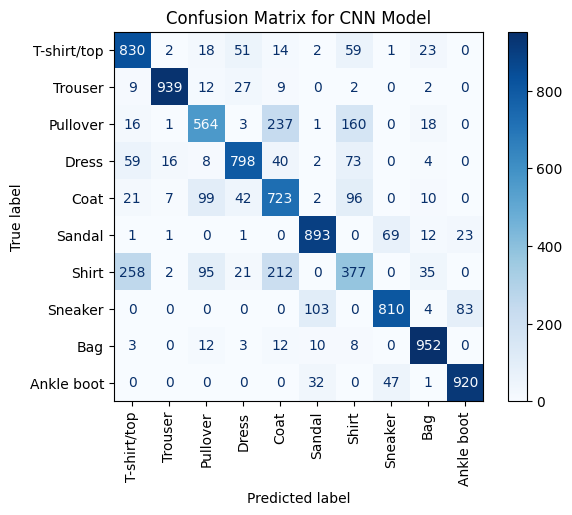

Test Accuracy: 0.7806


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions_lenet5_fmnist = model_lenet5_fmnist.predict(X_test_cnn)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions_lenet5_fmnist, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_cifar.argmax(axis=1), predicted_classes)

# Display the confusion matrix with class names
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=classes_cifar)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for CNN Model")
plt.show()

test_loss, test_accuracy = model_lenet5_fmnist.evaluate(X_test_cnn, y_test_cifar, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

**Which dataset seems easier for the model? What might be the cause?** Fashion MNIST is easier. There are multiple factors contributing:
- Grayscale vs. 3 color channels
- Topview vs. varying perspective
- Background separation vs. varying backgrounds
- In CIFAR, the variation within classes compared to the variation between classes is higher.

**Do you have an idea what changes are likely to improve the performance on the harder dataset?** This question is rather open, there are lots of things that can improve the performance. A few ideas:
- Using the full dataset and augmenting images
- More recent architectures
- Bigger search spaces for hyperparameter optimization, especially tuning of learning rate is known to improve performance


---

## 11.4 Logistic Regression as a baseline

Finally, we want to get an impression of how a baseline model like logistic regression performs on this dataset (this can take some time, in the range of minutes). And afterwards compute the confusion matrix.

**Tasks**:
Use the example structure below to fit LR models on both datasets and compare their performance. Try to answer the following questions:
- How do the LR models perform compared to the convolutional models?
- Is the difference between the datasets similar for both LR models and convolutional models?
- Would you say that the LR models performed well on both datasets? How is the structure of the data affecting the classification methods' performance?

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Flatten the images for logistic regression
X_train_flat = X_train_fmnist.reshape(X_train_fmnist.shape[0], -1)  # Shape (50000, 3072)
X_test_flat = X_test_fmnist.reshape(X_test_fmnist.shape[0], -1)     # Shape (10000, 3072)

# Train logistic regression
logistic_regression = LogisticRegression(
    max_iter=20,  # Increase iterations for convergence
    multi_class='multinomial',
    solver='saga',
    random_state=42
)
logistic_regression.fit(X_train_flat, y_train_fmnist.argmax(axis=1))

# Predict on the test set
y_pred = logistic_regression.predict(X_test_flat)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test_fmnist.argmax(axis=1), y_pred)
print("Test accuracy:", test_accuracy)

/home/flo/.conda/envs/tutorial/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.8015


/home/flo/.conda/envs/tutorial/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Flatten the images for logistic regression
X_train_flat = X_train_cifar.reshape(X_train_cifar.shape[0], -1)  # Shape (50000, 3072)
X_test_flat = X_test_cifar.reshape(X_test_cifar.shape[0], -1)     # Shape (10000, 3072)

# Train logistic regression
logistic_regression = LogisticRegression(
    max_iter=20,  # Increase iterations for convergence
    multi_class='multinomial',
    solver='saga',
    random_state=42
)
logistic_regression.fit(X_train_flat, y_train_cifar.argmax(axis=1))

# Predict on the test set
y_pred = logistic_regression.predict(X_test_flat)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test_cifar.argmax(axis=1), y_pred)
print("Test accuracy:", test_accuracy)


/home/flo/.conda/envs/tutorial/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.4138


/home/flo/.conda/envs/tutorial/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**How do the LR models perform compared to the convolutional models?** While logistic regression performs on par with the modern CNN, it performs better than LeNet5 on Fashion MNIST. On CIFAR-10, logistic regression performs worse than both convolutional architectures.
**Is the difference between the datasets similar for both LR models and convolutional models?** Yes, the differences are substantial in both cases. For the LeNet5, the difference is about 33% accuracy, while the logistic regression difference is almost 40%. 
**Would you say that the LR models performed well on both datasets? How is the structure of the data affecting the classification methods' performance?** Logistic regression performs poorly on CIFAR-10 but good on Fashion MNIST. This means that the pixel values of Fashion MNIST are (mostly) linearly separable. This could be connected to the fact that with the white background and centered & cropped images, FMNIST is mostly about shape recognition. So there are a few locations that presumably are only occupied for certain classes. This theory could be explored further by examining the fitted coefficients of pixel values to see which regions are relevant for which class (class-specific feature importance).

<div style="text-align: right;">
<i>This notebook has been created with the help of ChatGPT-4, 14.11.2024; Explanations were initially generated and afterwards edited;</i>
</div>